<a href="https://colab.research.google.com/github/ezekumar/Deeplearning/blob/master/Deeplearning_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Find the Resistance ohms value using deeplearning **

We worked out the four band color code resistor value prediction 

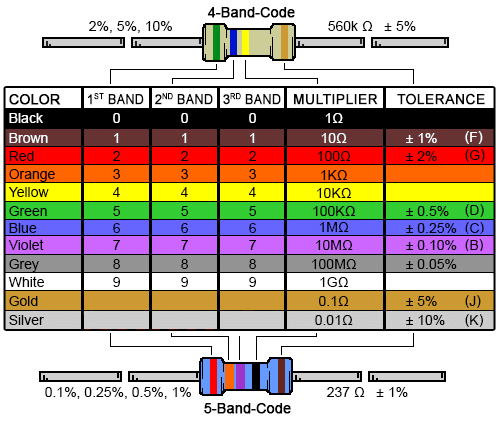

In [51]:
!pip install --upgrade tensorflow
!pip install -q git+https://github.com/tensorflow/docs


Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc2)


## Step 0: Import libraries




In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import zscore
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt




###Step 2: Loading Data Loading the dataset from the Resister_data.csv file.
The dataset will be loaded into Dataframe which is further used for data pre-processing and exploratory data analysis

In [0]:
url = 'https://raw.githubusercontent.com/ezekumar/Deeplearning/master/Resister_data.csv'
dataset = pd.read_csv(url)


###Step 3: Exploratory Data Analysis
Information about the data The scheme of the data can be explored by examining the information about the dataset such as number of entries, column count, data type of the columns and the null constraints. As part of the Exploratory Data Analysis, we need to find out the properties of the attributes and identify the suitable variables for further analysis.

In [54]:

dataset.shape
dataset.columns
dataset.info()
dataset.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Band_1                45 non-null     object
 1   Band_2                45 non-null     object
 2   Band_3                45 non-null     object
 3   Band_4                45 non-null     object
 4   Resistor Value(ohms)  45 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.9+ KB


,Resistor Value(ohms)
count,4.500000e+01
mean,1.678478e+05
std,3.363203e+05
min,1.000000e+02
25%,6.000000e+03
50%,1.800000e+04
75%,1.500000e+05
max,1.800000e+06


###Normalization need to perform the resister value

In [55]:

numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset[numeric_cols]=dataset[numeric_cols].apply(zscore)
dataset.head()


,Band_1,Band_2,Band_3,Band_4,Resistor Value(ohms)
0,GREY,RED,ORANGE,GOLD,-0.258140
1,GREEN,BLUE,RED,GOLD,-0.487872
2,BROWN,BLACK,RED,GOLD,-0.501704
3,GREEN,BLUE,YELLOW,GOLD,1.179184
4,ORANGE,ORANGE,RED,GOLD,-0.494788


###Preprocessing the categorical feature

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)
            df.drop([col],axis = 1 , inplace=True)
    return df

cat_cols =['Band_1','Band_2','Band_3','Band_4']
dataset = oneHotEncode(dataset, cat_cols)



[]

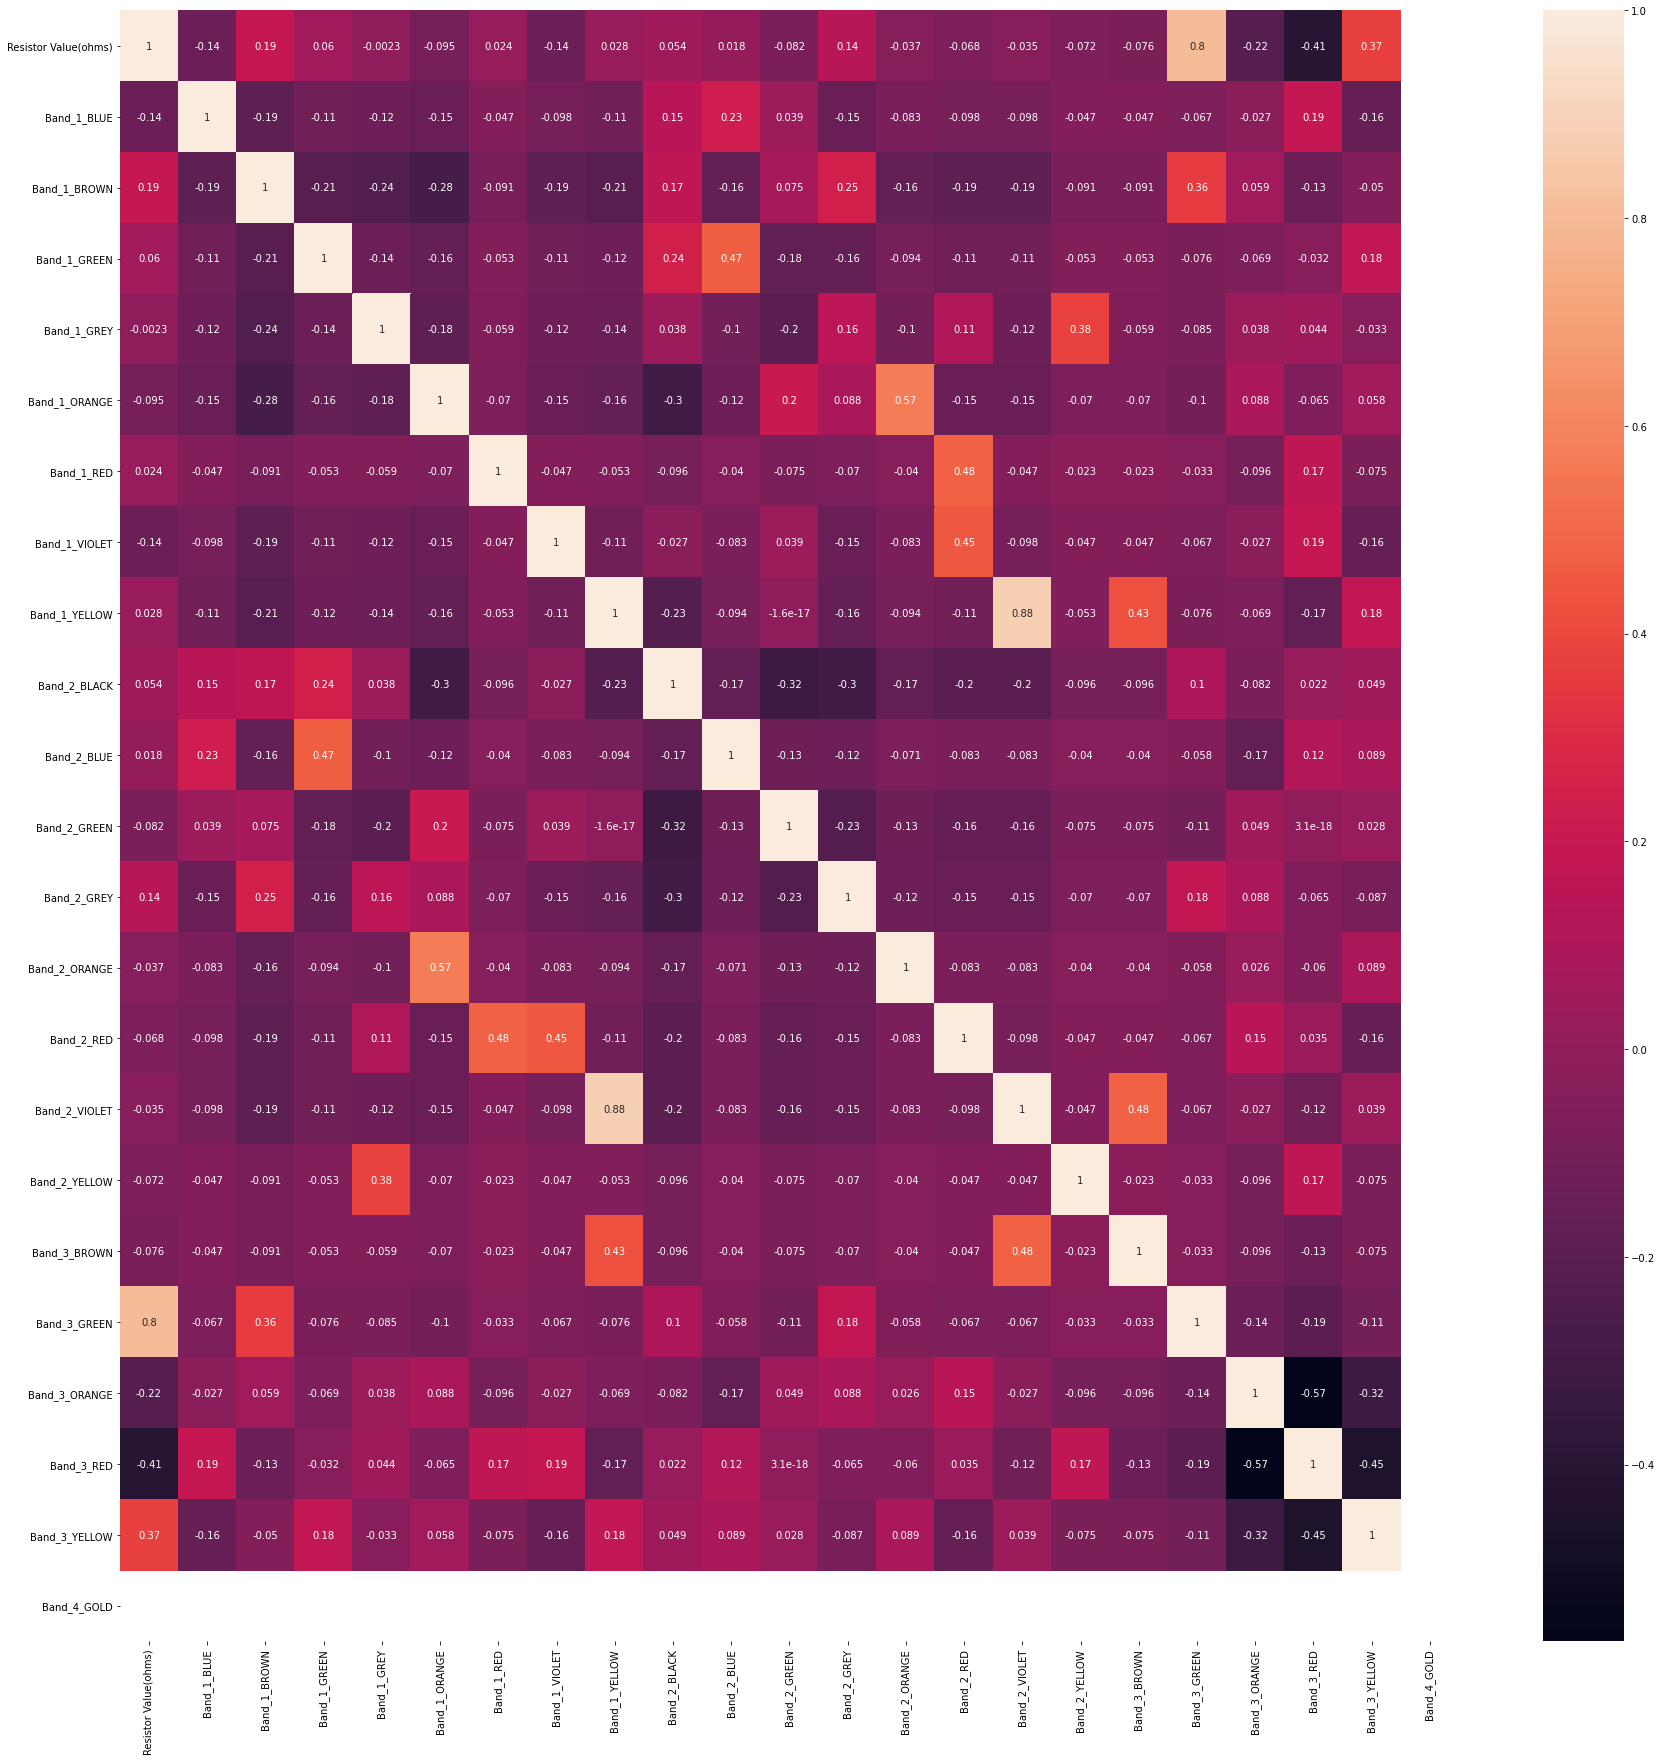

In [57]:
#Correlation Feature matrix
plt.figure(figsize=(30,30))
sns.heatmap(dataset.corr(),annot=True)
plt.plot()

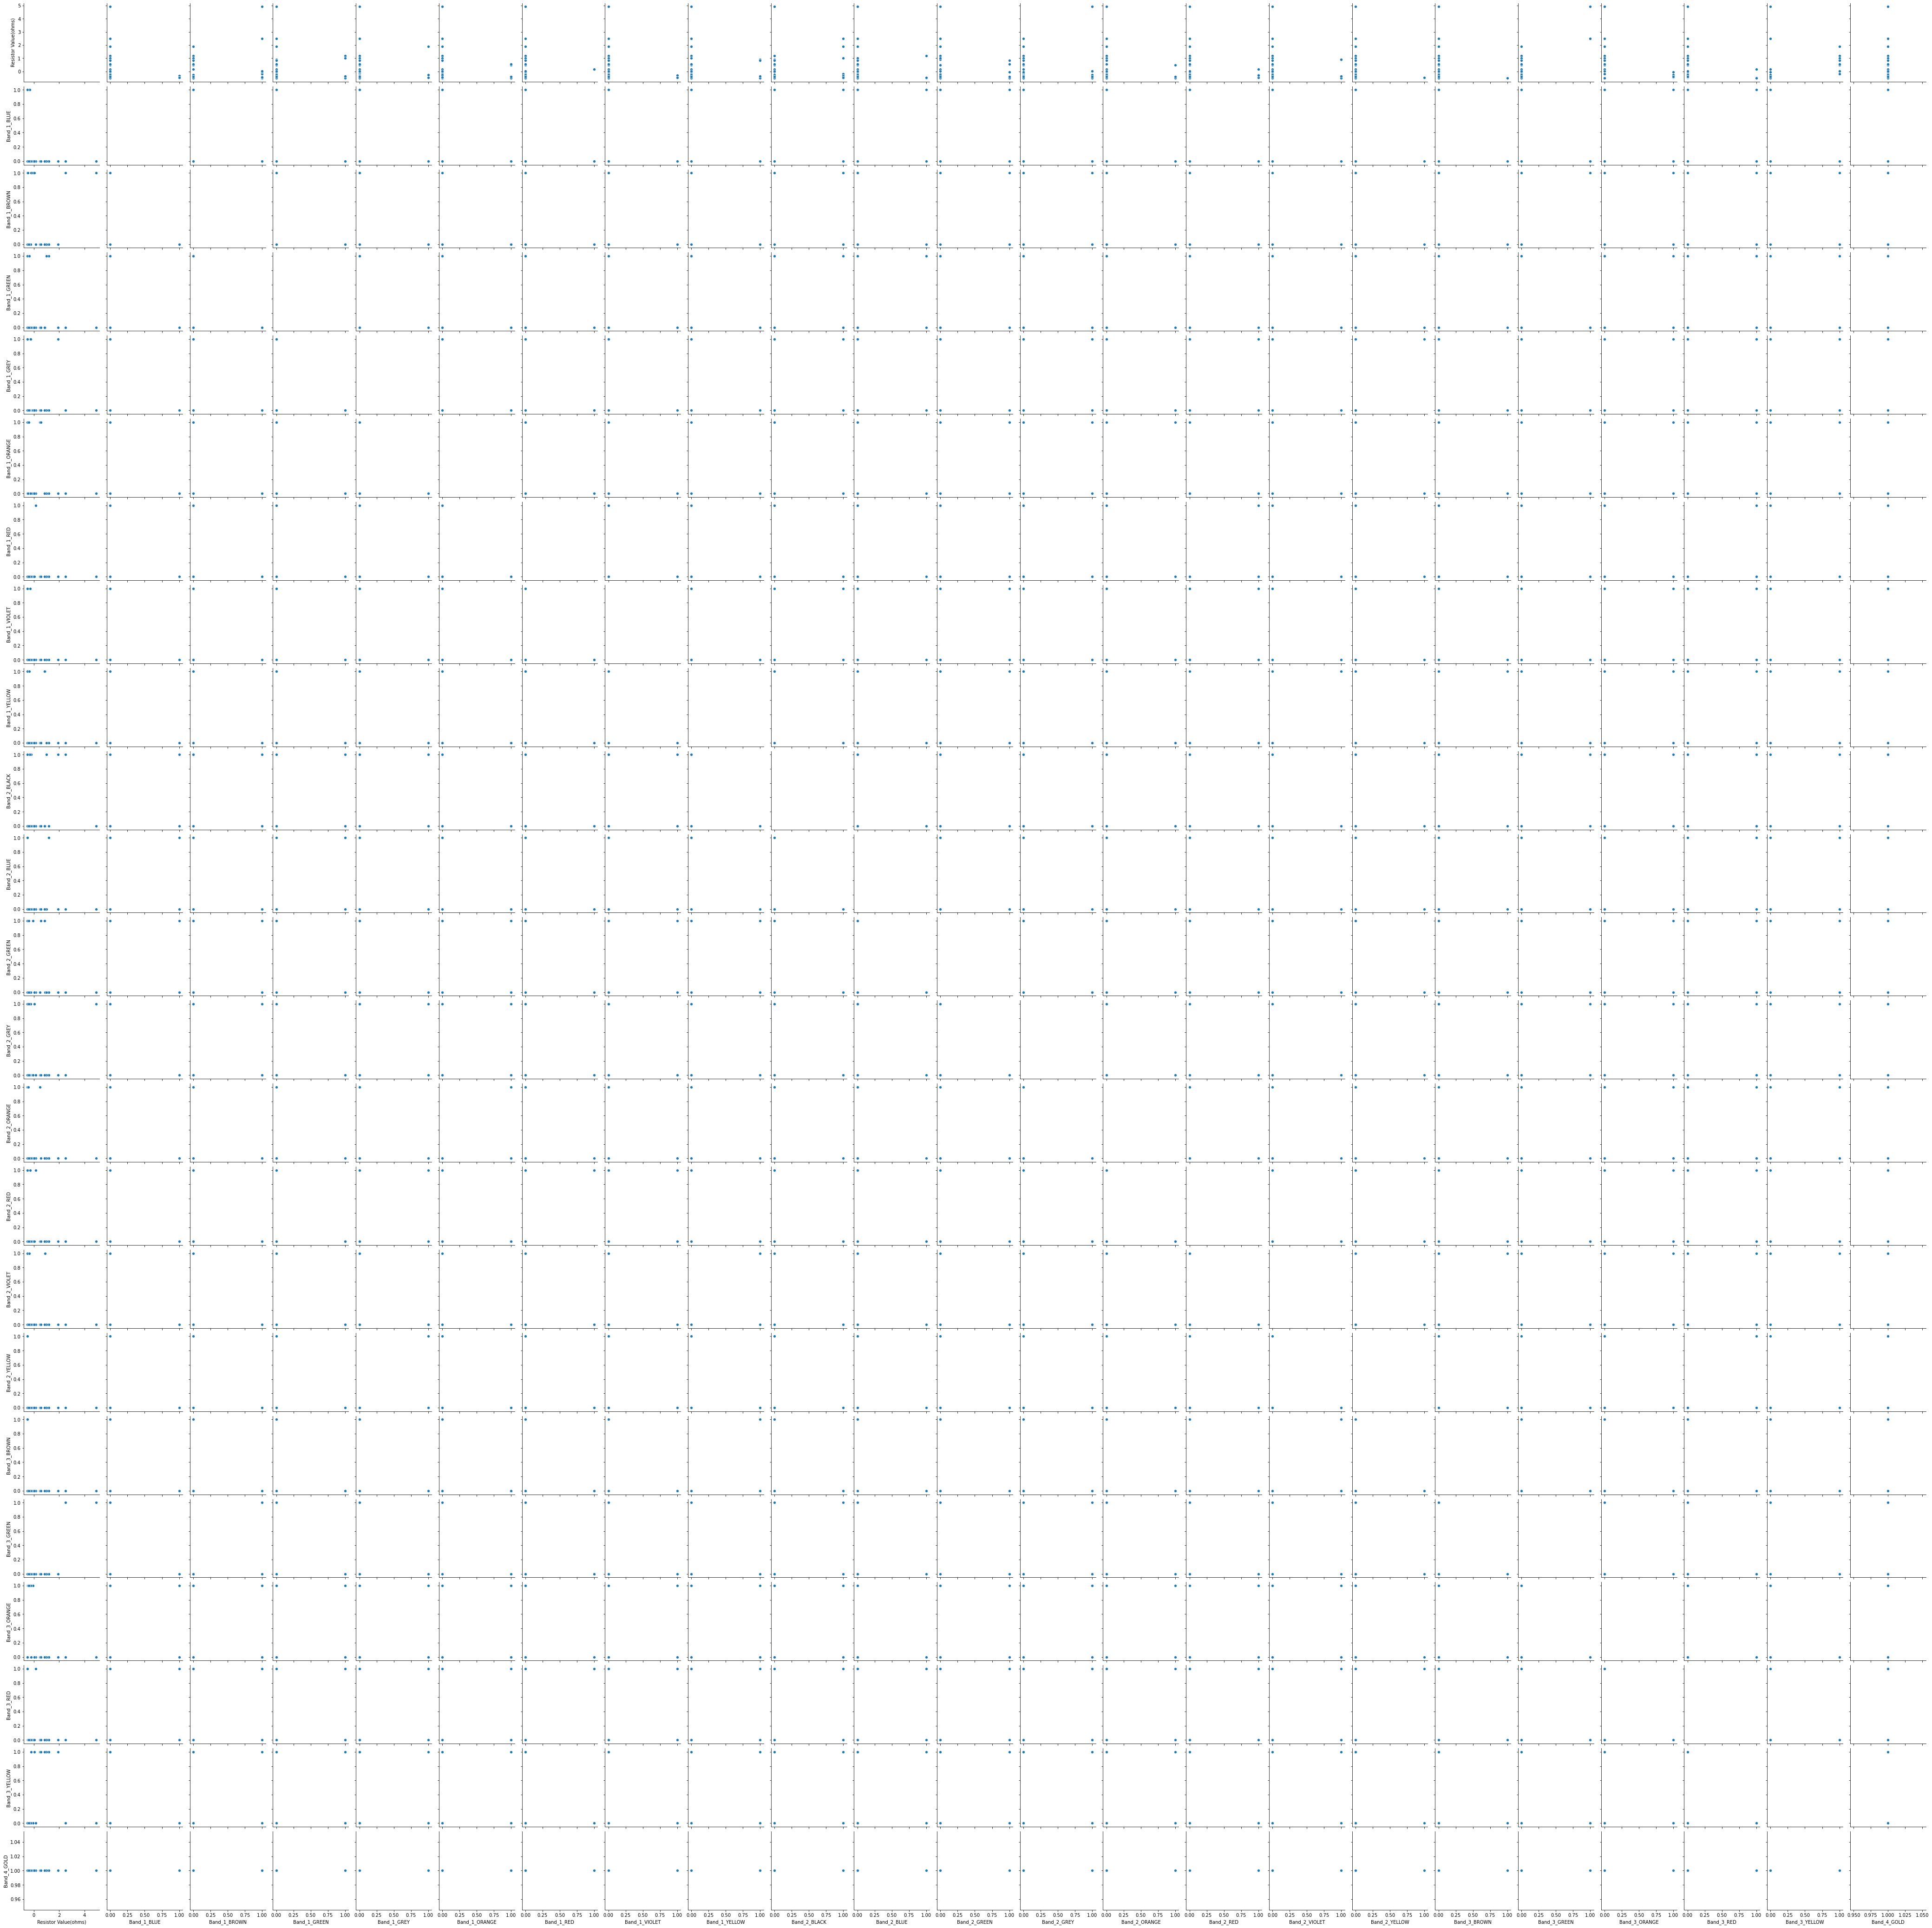

In [58]:
import seaborn as sns
sns.pairplot(dataset, diag_kind="corr")

###Split the data into train and test

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


###Split features from labels

In [0]:
train_labels = train_dataset.pop('Resistor Value(ohms)')
test_labels = test_dataset.pop('Resistor Value(ohms)')

###Build the model
###Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model

In [0]:
def build_model():
 
  model = keras.Sequential([
    layers.Dense(22, activation='relu',input_shape=[len(train_dataset.keys())]),
    layers.Dense(22, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

###Train the model
###Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [62]:
model = build_model()
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])



Epoch: 0, loss:0.6486,  mae:0.5774,  mse:0.6486,  val_loss:0.2212,  val_mae:0.4471,  val_mse:0.2212,  
............................................................

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_4 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 23        
Total params: 1,035
Trainable params: 1,035
Non-trainable params: 0
_________________________________________________________________


Text(0, 0.5, 'MAE [Resistor (ohms)]')

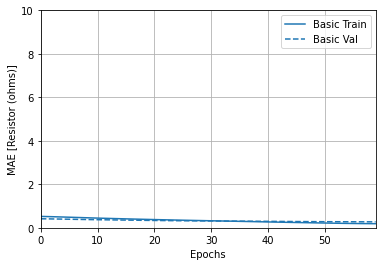

In [64]:
import matplotlib.pyplot as plt
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Resistor (ohms)]')

In [65]:
loss, mae, mse = model.evaluate(test_dataset,test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Resiter value".format(mae))

1/1 - 0s - loss: 2.3610 - mae: 0.8003 - mse: 2.3610
Testing set Mean Abs Error:  0.80 Resiter value


Text(0, 0.5, 'MAE [Resiter value]')

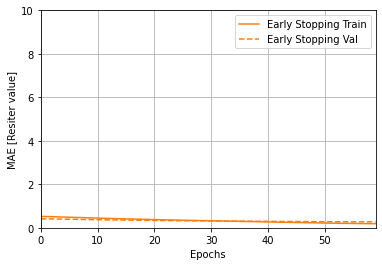

In [66]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Resiter value]')

###Make predictions

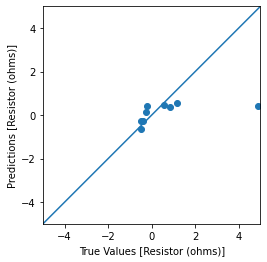

In [67]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Resistor (ohms)]')
plt.ylabel('Predictions [Resistor (ohms)]')
lims = [-5, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)